In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
from pathlib import Path
from datetime import datetime
from typing import Dict
from easydict import EasyDict
from tqdm.auto import tqdm

from objprint import objstr

from matplotlib import pyplot as plt

In [4]:
import torch
import monai
from monai.utils import ensure_tuple_rep
from accelerate import Accelerator
from timm.optim import optim_factory

In [5]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [6]:
if device.startswith("cu"):
    print(torch.cuda.get_device_name(device))

Tesla P100-PCIE-16GB


In [7]:
from src import utils
from src.loader import get_dataloader
from src.optimizer import LinearWarmupCosineAnnealingLR
from src.SlimUNETR.SlimUNETR import SlimUNETR
from src.utils import Logger, same_seeds, load_config

In [8]:
def _train_loop(
    model: torch.nn.Module,
    loss_functions: Dict[str, torch.nn.modules.loss._Loss],
    train_loader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    post_trans: monai.transforms.Compose,
    metrics: Dict[str, monai.metrics.CumulativeIterationMetric],
    accelerator: Accelerator,
    step: int
):
    accelerator.print("Start train loop!")
    device = next(model.parameters()).device
    model.train()
    for i, image_batch in enumerate(tqdm(train_loader)):
        logits = model(image_batch["image"].to(device))
        total_loss = 0
        log = ""
        for name in loss_functions:
            alpth = 1
            loss = loss_functions[name](logits, image_batch["label"].to(device))
            accelerator.log({"Train/" + name: float(loss)}, step=step)
            total_loss += alpth * loss
        
        val_outputs = [post_trans(i) for i in logits]
        for metric_name in metrics:
            metrics[metric_name](y_pred=val_outputs, y=image_batch["label"])

        accelerator.backward(total_loss)
        optimizer.step()
        optimizer.zero_grad()
        accelerator.log(
            {
                "Train/Total Loss": float(total_loss),
            },
            step=step,
        )
        accelerator.print(
            f"Epoch [{epoch + 1}/{config.trainer.num_epochs}] Training [{i + 1}/{len(train_loader)}] Loss: {total_loss:1.5f} {log}",
            flush=True,
        )
        step += 1

def _get_metrics_dict(metrics, accelerator, is_HepaticVessel):
    metric = {}
    for metric_name in metrics:
        batch_acc = metrics[metric_name].aggregate()
        if accelerator.num_processes > 1:
            batch_acc = accelerator.reduce(batch_acc) / accelerator.num_processes

        metric[f"Train/mean {metric_name}"] = float(batch_acc.mean())

        if is_HepaticVessel:
            metric.update({
            f"Train/Hepatic Vessel {metric_name}": float(batch_acc[0]),
            f"Train/Tumors {metric_name}": float(batch_acc[1])
            })
        else:
            metric.update({
            f"Train/TC {metric_name}": float(batch_acc[0]),
            f"Train/WT {metric_name}": float(batch_acc[1]),
            f"Train/ET {metric_name}": float(batch_acc[2])
            })

    return metric

@torch.no_grad()
def val_one_epoch(
    model: torch.nn.Module,
    is_HepaticVessel: bool,
    loss_functions: Dict[str, torch.nn.modules.loss._Loss],
    inference: monai.inferers.Inferer,
    val_loader: torch.utils.data.DataLoader,
    config: EasyDict,
    metrics: Dict[str, monai.metrics.CumulativeIterationMetric],
    step: int,
    post_trans: monai.transforms.Compose,
    accelerator: Accelerator,
    epoch: int,
):
    # val
    device = next(model.parameters()).device
    print(device)
    model.eval()
    for i, image_batch in enumerate(tqdm(val_loader)):
        logits = inference(image_batch["image"].to(device), model)
        total_loss = 0
        log = ""
        for name in loss_functions:
            loss = loss_functions[name](logits, image_batch["label"].to(device))
            accelerator.log({"Val/" + name: float(loss)}, step=step)
            log += f" {name} {float(loss):1.5f} "
            total_loss += loss
        val_outputs = [post_trans(i) for i in logits]
        for metric_name in metrics:
            metrics[metric_name](y_pred=val_outputs, y=image_batch["label"])
        accelerator.log(
            {
                "Val/Total Loss": float(total_loss),
            },
            step=step,
        )
        accelerator.print(
            f"Epoch [{epoch + 1}/{config.trainer.num_epochs}] Validation [{i + 1}/{len(val_loader)}] Loss: {total_loss:1.5f} {log}",
            flush=True,
        )
        step += 1

    metric = {}
    for metric_name in metrics:
        batch_acc = metrics[metric_name].aggregate()
        if accelerator.num_processes > 1:
            batch_acc = (
                accelerator.reduce(batch_acc.to(accelerator.device))
                / accelerator.num_processes
            )
        metrics[metric_name].reset()
        if is_HepaticVessel:
            metric.update(
                {
                    f"Val/mean {metric_name}": float(batch_acc.mean()),
                    f"Val/Hepatic Vessel {metric_name}": float(batch_acc[0]),
                    f"Val/Tumors {metric_name}": float(batch_acc[1]),
                }
            )
        else:
            metric.update(
                {
                    f"Val/mean {metric_name}": float(batch_acc.mean()),
                    f"Val/TC {metric_name}": float(batch_acc[0]),
                    f"Val/WT {metric_name}": float(batch_acc[1]),
                    f"Val/ET {metric_name}": float(batch_acc[2]),
                }
            )
    accelerator.print(
        f"Epoch [{epoch + 1}/{config.trainer.num_epochs}] Validation metric {metric}"
    )
    print(f"Epoch [{epoch + 1}/{config.trainer.num_epochs}] Validation metric {metric}")
    accelerator.log(metric, step=epoch)
    print(metric)
    return (
        torch.Tensor([metric["Val/mean dice_metric"]]).to(accelerator.device),
        batch_acc,
        step,
    )


def train_one_epoch(
    model: torch.nn.Module,
    config: EasyDict,
    is_HepaticVessel: bool,
    loss_functions: Dict[str, torch.nn.modules.loss._Loss],
    train_loader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    scheduler: torch.optim.lr_scheduler._LRScheduler,
    metrics: Dict[str, monai.metrics.CumulativeIterationMetric],
    post_trans: monai.transforms.Compose,
    accelerator: Accelerator,
    epoch: int,
    step: int,
):
    # train

    _train_loop(
        model,
        loss_functions,
        train_loader,
        optimizer,
        post_trans,
        metrics,
        accelerator,
        step
    )

    scheduler.step(epoch)
    metric = _get_metrics_dict(metrics, accelerator, is_HepaticVessel)

    accelerator.print(
        f"Epoch [{epoch + 1}/{config.trainer.num_epochs}] Training metric {metric}"
    )
    print(f"Epoch [{epoch + 1}/{config.trainer.num_epochs}] Training metric {metric}")
    accelerator.log(metric, step=epoch)
    print(metric)
    return step



In [9]:
config, data_flag, is_HepaticVessel = load_config()
config.trainer.batch_size = 4
data_flag

'tbad_dataset'

In [10]:
same_seeds(config.trainer.seed)
logging_dir = Path(os.getcwd()) / "logs" / str(datetime.now()).replace(":","_")
accelerator = Accelerator(
    cpu=False, log_with=["tensorboard"], project_dir=str(logging_dir)
)
Logger(logging_dir if accelerator.is_local_main_process else None)
accelerator.init_trackers('main')
accelerator.print(objstr(config))

accelerator.print("Load Model...")
model = SlimUNETR(**config.slim_unetr)
model.to(device)
image_size = config.trainer.image_size

accelerator.print("Load Dataloader...")
train_loader, val_loader = get_dataloader(config, data_flag)

<EasyDict 0x17e31340bf0
  'data_root': '../med_data/common/imageTBAD_MSD_rs',
  'finetune': <EasyDict 0x17e31340cb0
    'checkpoint': 'tbad_dataset'
  >,
  'slim_unetr': <EasyDict 0x17e31340d10
    'blocks': [2, 3, 4, 3],
    'channels': [24, 64, 96],
    'dropout': 0.3,
    'embed_dim': 96,
    'embedding_dim': 64,
    'heads': [1, 2, 4, 4],
    'in_channels': 1,
    'out_channels': 3,
    'r': [4, 2, 2, 1]
  >,
  'trainer': <EasyDict 0x17e31340c50
    'batch_size': 4,
    'image_size': 128,
    'lr': 0.001,
    'min_lr': 5e-06,
    'momentum_teacher': 0.996,
    'num_epochs': 400,
    'num_workers': 0,
    'optimizer': 'adamw',
    'pred_ratio_var': 0,
    'resume': True,
    'rot_prob': 0.8,
    'seed': 50,
    'train_ratio': 0.8,
    'warmup': 20,
    'weight_decay': 0.05,
    'weight_decay_end': 0.04
  >
>
Load Model...
Load Dataloader...
c:\Users\DenisMiX\miniconda3\envs\slim-unetr\Lib\site-packages\monai\utils\deprecate_utils.py:321: FutureWarning: monai.transforms.io.dictionary

In [11]:
inference = monai.inferers.SlidingWindowInferer(
    roi_size=ensure_tuple_rep(image_size, 3),
    overlap=0.5,
    sw_device=accelerator.device,
    device=accelerator.device,
)
metrics = {
    "dice_metric": monai.metrics.DiceMetric(
        include_background=True,
        reduction=monai.utils.MetricReduction.MEAN_BATCH,
        get_not_nans=False,
    ),
    # 'hd95_metric': monai.metrics.HausdorffDistanceMetric(percentile=95, include_background=True, reduction=monai.utils.MetricReduction.MEAN_BATCH, get_not_nans=False)
}
post_trans = monai.transforms.Compose(
    [
        monai.transforms.Activations(sigmoid=True),
        monai.transforms.AsDiscrete(threshold=0.5),
    ]
)

In [12]:
optimizer = optim_factory.create_optimizer_v2(
    model,
    opt=config.trainer.optimizer,
    weight_decay=config.trainer.weight_decay,
    lr=config.trainer.lr,
    betas=(0.9, 0.95),
)
scheduler = LinearWarmupCosineAnnealingLR(
    optimizer,
    warmup_epochs=config.trainer.warmup,
    max_epochs=config.trainer.num_epochs,
)
loss_functions = {
    "focal_loss": monai.losses.FocalLoss(to_onehot_y=False),
    "dice_loss": monai.losses.DiceLoss(
        smooth_nr=0, smooth_dr=1e-5, to_onehot_y=False, sigmoid=True
    ),
}


In [13]:
config.trainer.resume

True

In [14]:
from src.unet3d import ResidualUNet3D

In [15]:
# model = ResidualUNet3D(
#     in_channels=config.slim_unetr.in_channels,
#     out_channels=config.slim_unetr.out_channels,
#     f_maps=config.slim_unetr.channels,
#     layer_order="cl",
#     num_groups=None,
#     dropout_prob=config.slim_unetr.dropout,
#     final_sigmoid=False,

# ).cuda()

In [16]:
# setup training
if True:
    base_exp_path = f"{os.getcwd()}/model_store/{config.finetune.checkpoint}/seed{config.trainer.seed}/ims_{config.trainer.image_size}_rot_prob{config.trainer.rot_prob}_leaky_relu"

    model, starting_epoch, step, val_step = utils.resume_train_state(
        model, base_exp_path, train_loader, accelerator
    )
    print("Resuming training from epoch {}".format(starting_epoch))
else:
    starting_epoch = 0
    step, val_step = 0, 0
    best_acc, best_class = 0, []

    model, optimizer, scheduler, train_loader, val_loader = accelerator.prepare(
        model, optimizer, scheduler, train_loader, val_loader
    )

try to load c:\Users\DenisMiX\sandbox\medical\Slim-UNETR\model_store\tbad_dataset\seed50\ims_128_rot_prob0.8_leaky_relu\epoch_354 train stage
Successfully loaded the training model！
Load state training success ！Start from 355 epoch
Resuming training from epoch 355
torch.Size([4, 1, 128, 128, 128])
[-0.80053693 -0.7746238  -0.7644468  ...  8.708637    8.81174
  9.061637  ]


In [17]:
model

SlimUNETR(
  (encoder): Encoder(
    (DWconv1): DepthwiseConvLayer(
      (depth_wise): Conv3d(1, 24, kernel_size=(4, 4, 4), stride=(4, 4, 4))
      (norm): GroupNorm(1, 24, eps=1e-05, affine=True)
    )
    (DWconv2): DepthwiseConvLayer(
      (depth_wise): Conv3d(24, 64, kernel_size=(2, 2, 2), stride=(2, 2, 2))
      (norm): GroupNorm(1, 64, eps=1e-05, affine=True)
    )
    (DWconv3): DepthwiseConvLayer(
      (depth_wise): Conv3d(64, 96, kernel_size=(2, 2, 2), stride=(2, 2, 2))
      (norm): GroupNorm(1, 96, eps=1e-05, affine=True)
    )
    (DWconv4): DepthwiseConvLayer(
      (depth_wise): Conv3d(96, 96, kernel_size=(2, 2, 2), stride=(2, 2, 2))
      (norm): GroupNorm(1, 96, eps=1e-05, affine=True)
    )
    (block1): Sequential(
      (0): Block(
        (patch1): PatchPartition(
          (positional_encoding): Conv3d(24, 24, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), groups=24, bias=False)
        )
        (LocalRC): LocalRepresentationsCongregation(
        

In [18]:
starting_epoch

355

In [19]:
next(model.parameters()).device

device(type='cuda', index=0)

In [20]:
from torch import nn

def _weights_init(m):

    classname = m.__class__.__name__

    if isinstance(m, (nn.Conv3d, nn.Linear, nn.ConvTranspose3d)):
        nn.init.kaiming_uniform_(m.weight, a=10e-6)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif classname.find('Norm') != -1:
        m.weight.data.fill_(10e-7)
        nn.init.zeros_(m.bias)

In [23]:
import numpy as np

In [21]:
device = next(model.parameters()).device
model.train()
step = 0
for i, image_batch in enumerate(tqdm(val_loader)):
    accelerator.print(image_batch["image"].shape)
    logits = model(image_batch["image"].to(device))
    val_outputs = [post_trans(logit) for logit in logits]
    
    # accelerator.print(str([hidden.shape for hidden in model.hidden_states_out]))
    
    # total_loss = 0
    # for name in loss_functions:
    #     loss = loss_functions[name](logits, image_batch["label"].to(device))
    #     accelerator.log({"Train/" + name: float(loss)}, step=step)
    #     total_loss += loss
    
    # val_outputs = [post_trans(i) for i in logits]
    # for metric_name in metrics:
    #     metrics[metric_name](
    #         y_pred=val_outputs, 
    #         y=image_batch["label"].to(device)
    #     )

    # accelerator.backward(total_loss)
    # optimizer.step()
    # optimizer.zero_grad()
    # accelerator.log(
    #     {
    #         "Train/Total Loss": float(total_loss),
    #     },
    #     step=step,
    # )
    # accelerator.print(
    #     f"Training [{i + 1}/{len(train_loader)}] Loss: {total_loss:1.5f}",
    #     flush=True,
    # )
    # step += 1
    break

  0%|          | 0/5 [00:00<?, ?it/s]

In [28]:
post_trans

In [27]:
np.unique(val_outputs[0])

array([0., 1.], dtype=float32)

In [25]:
np.unique(logits.detach().cpu().numpy())

array([-0.80053693, -0.7746238 , -0.7644468 , ...,  8.708637  ,
        8.81174   ,  9.061637  ], dtype=float32)

In [20]:
image_batch["image"].shape


torch.Size([4, 1, 128, 128, 128])

In [21]:
image_batch["label"].shape

torch.Size([4, 3, 128, 128, 128])

In [29]:
image_batch["image"][3, ...].shape

torch.Size([1, 128, 128, 128])

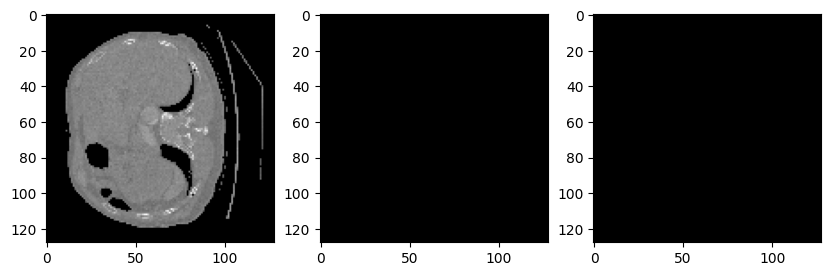

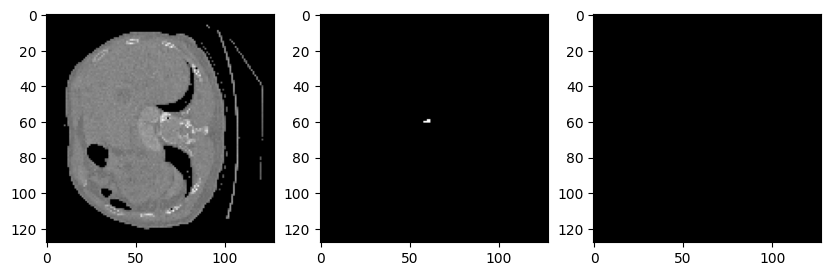

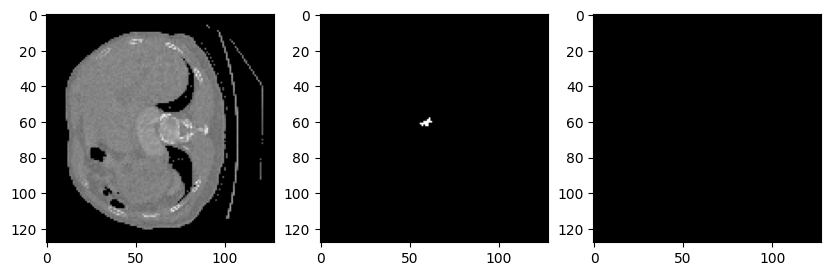

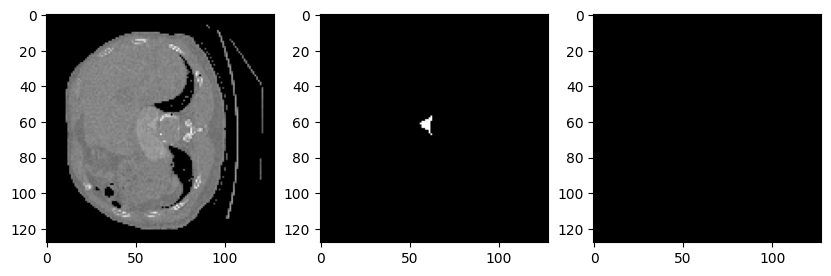

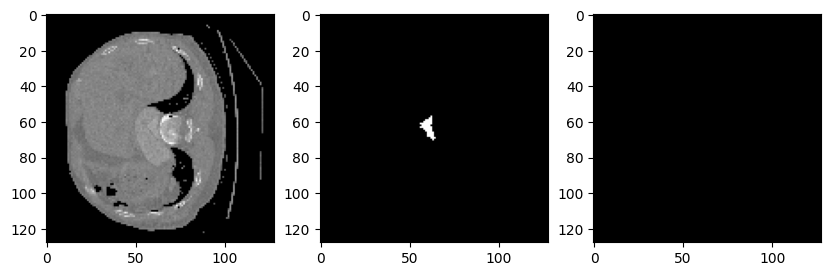

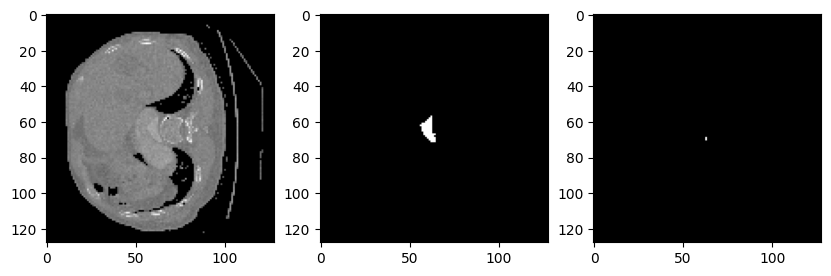

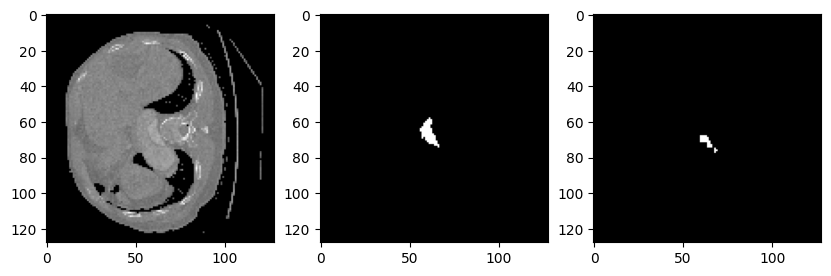

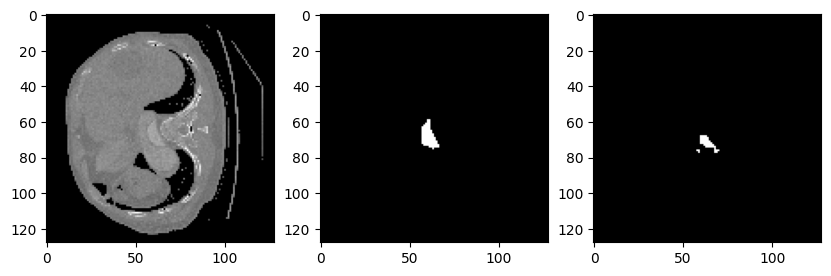

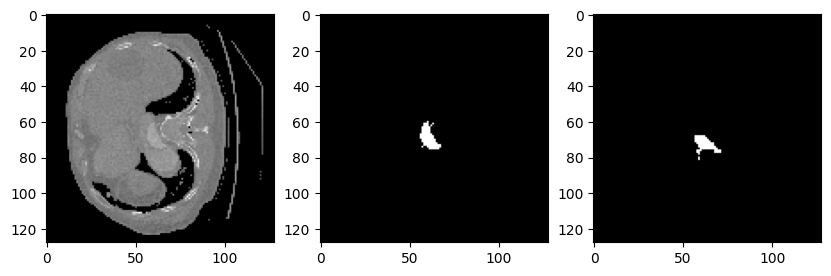

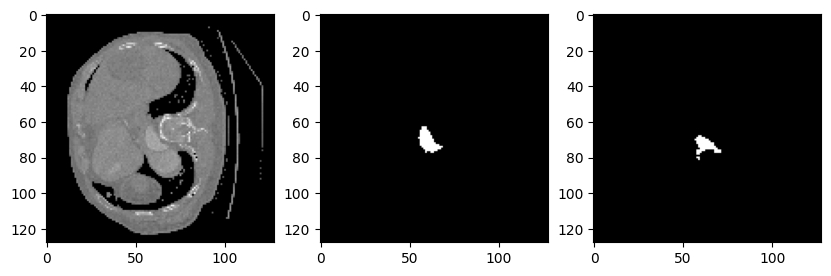

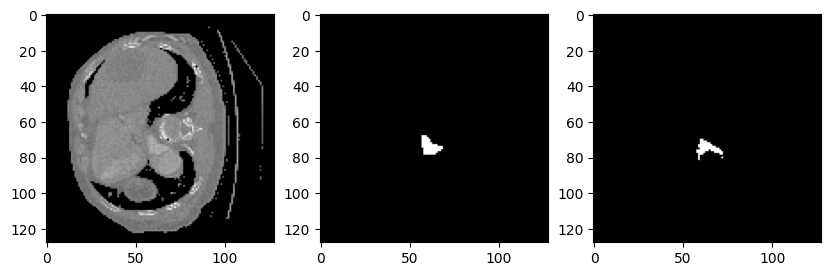

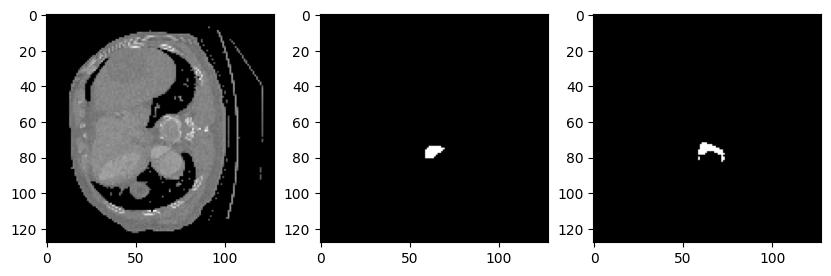

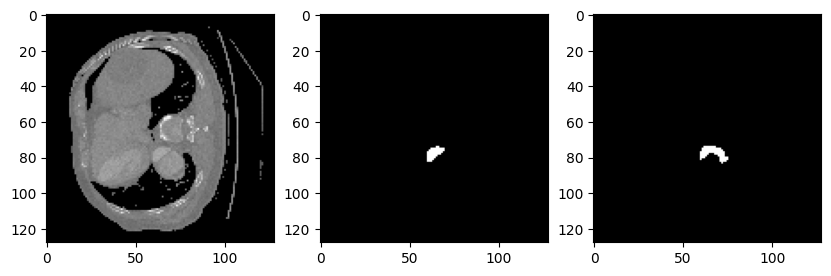

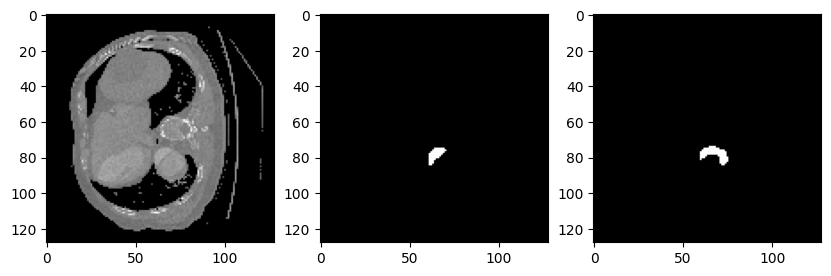

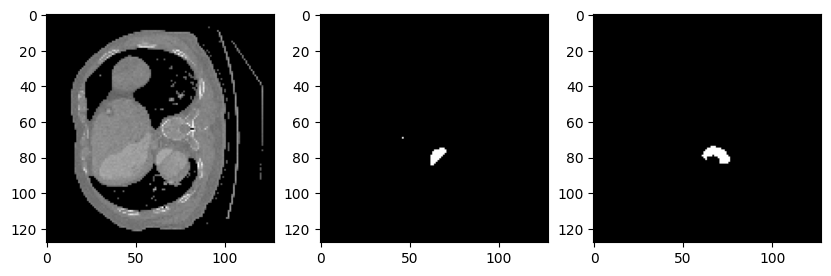

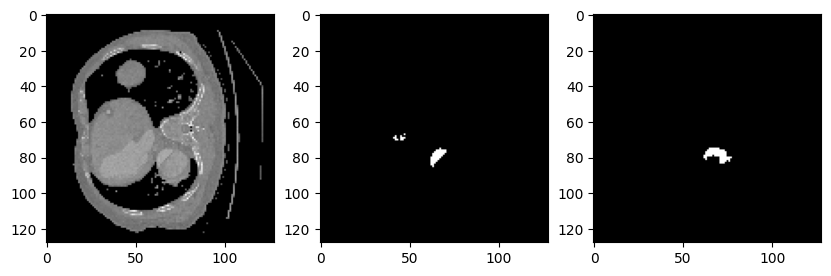

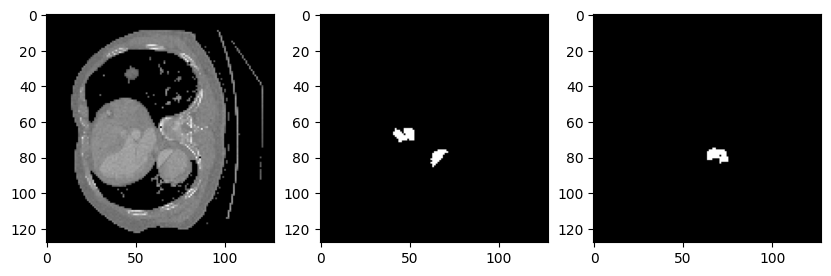

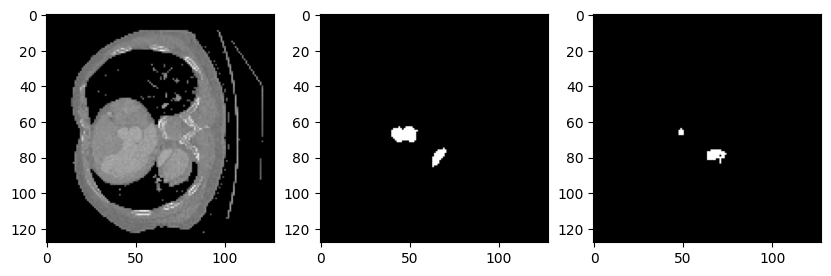

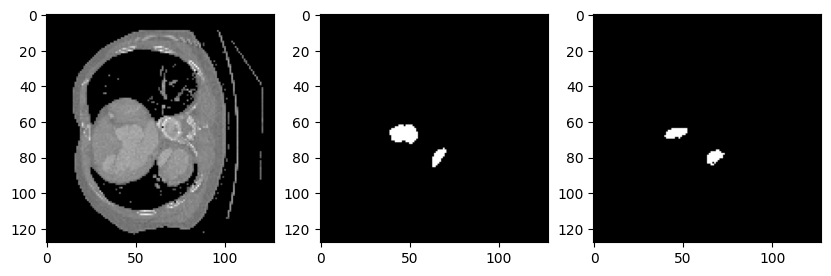

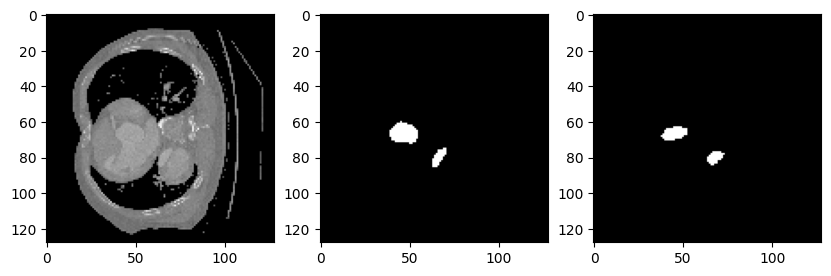

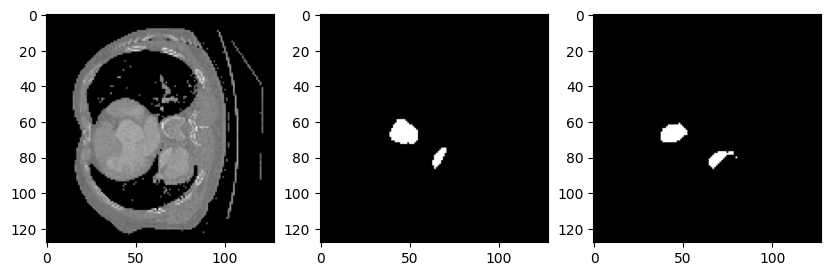

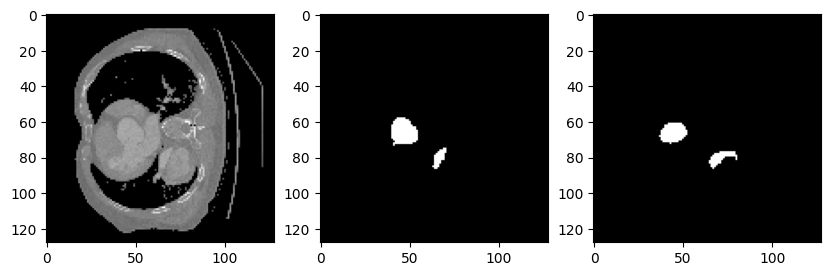

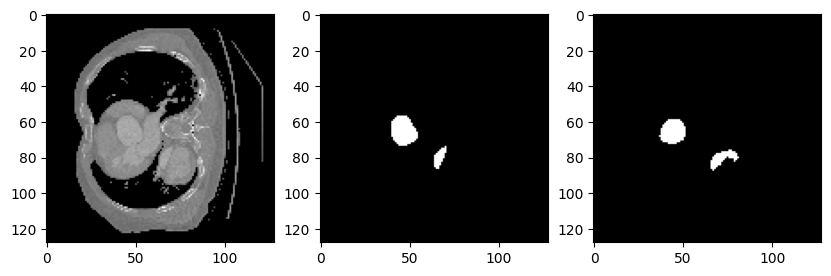

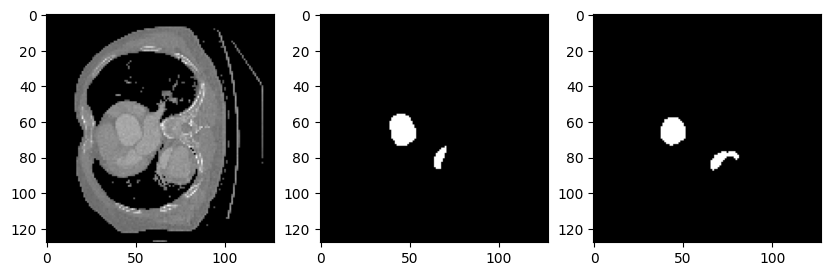

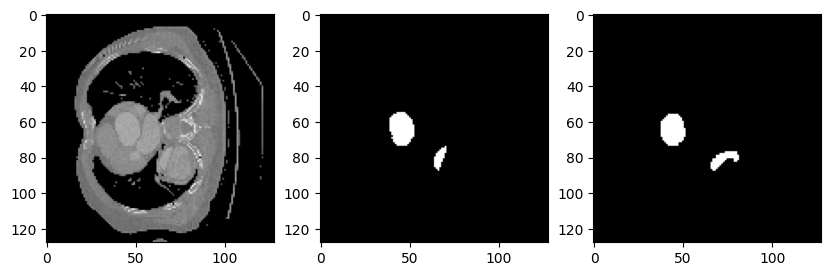

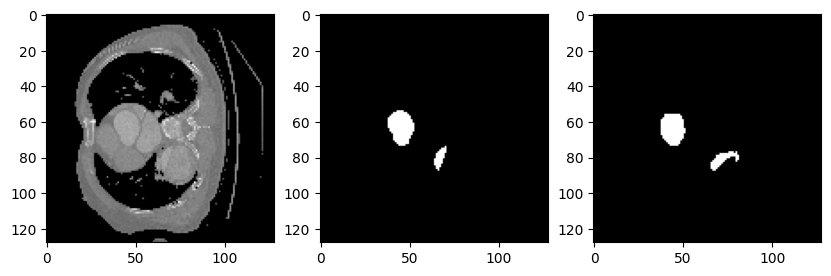

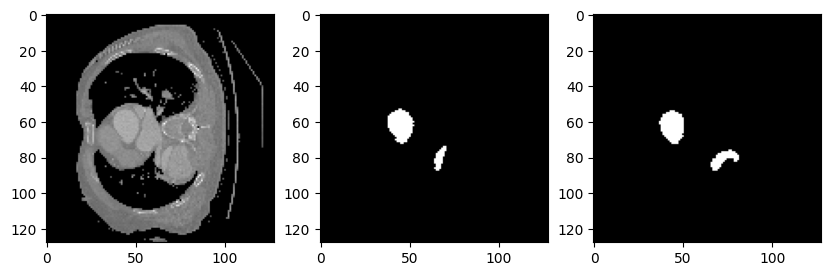

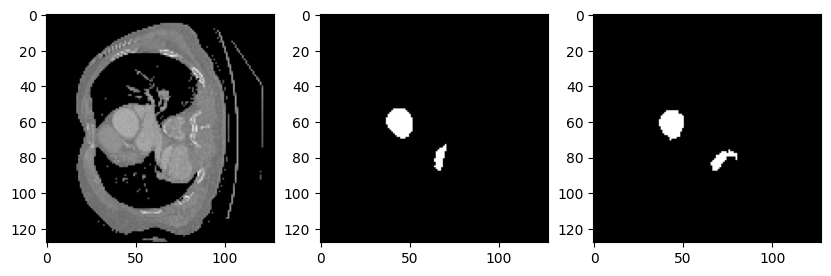

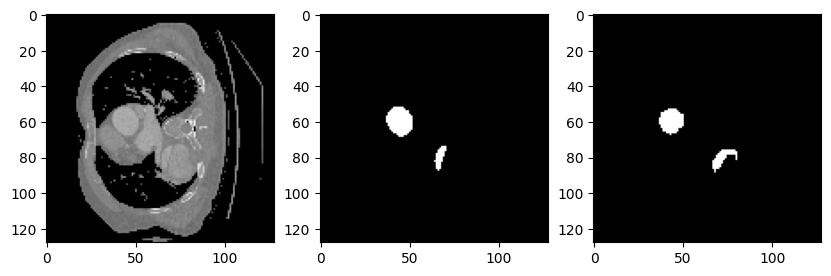

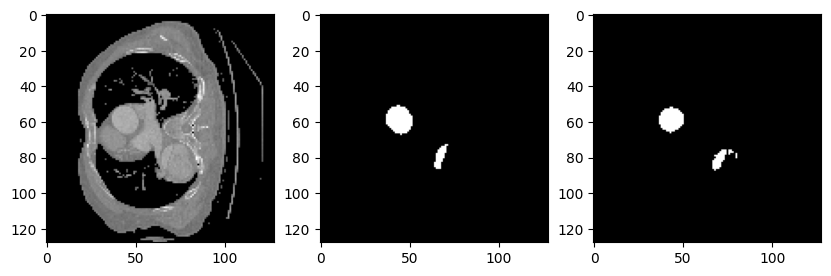

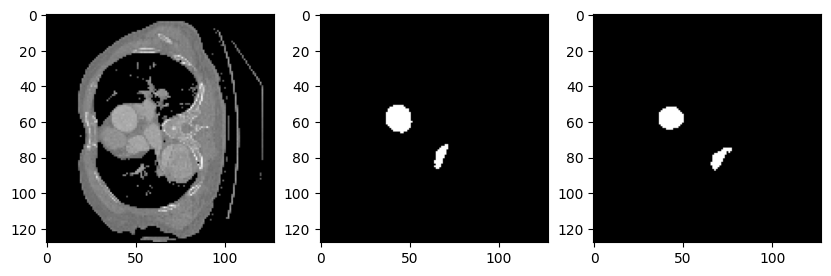

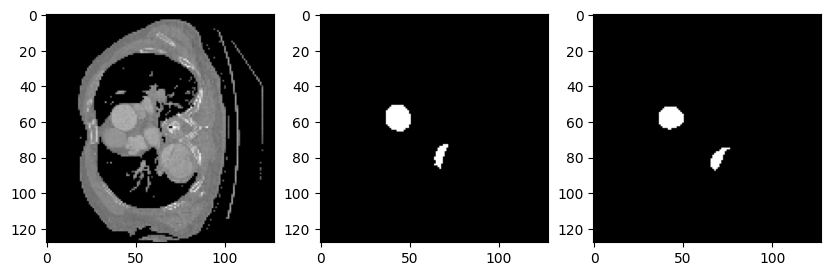

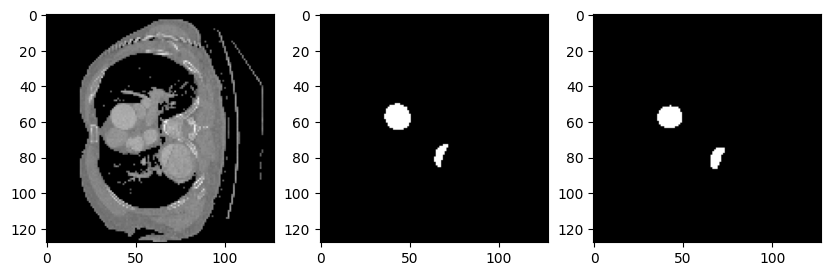

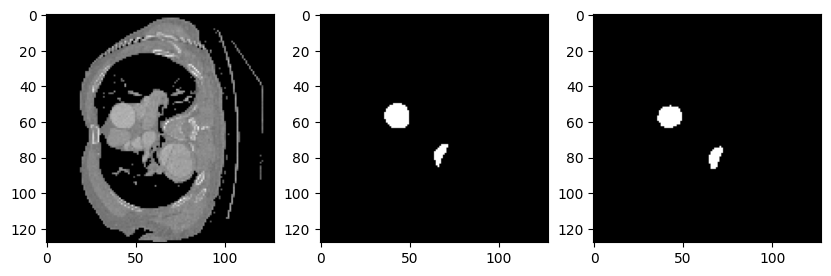

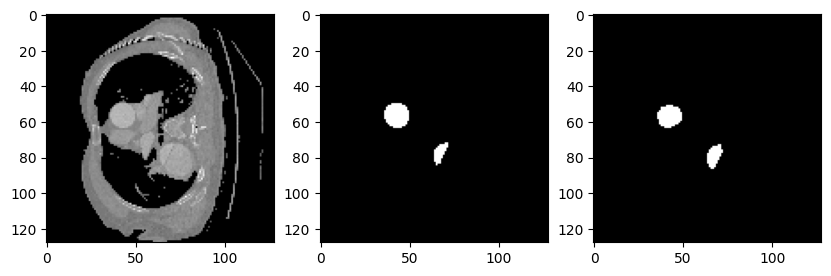

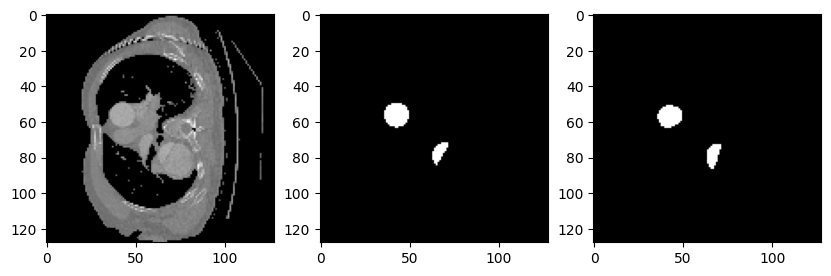

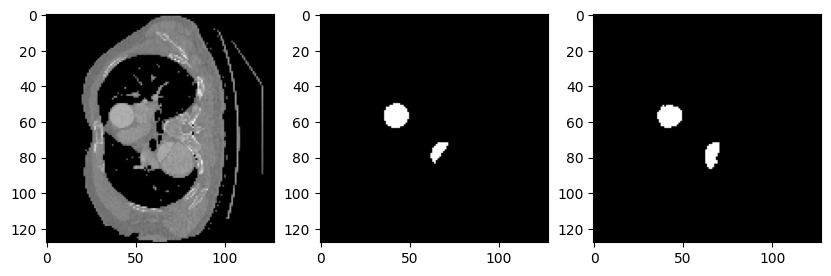

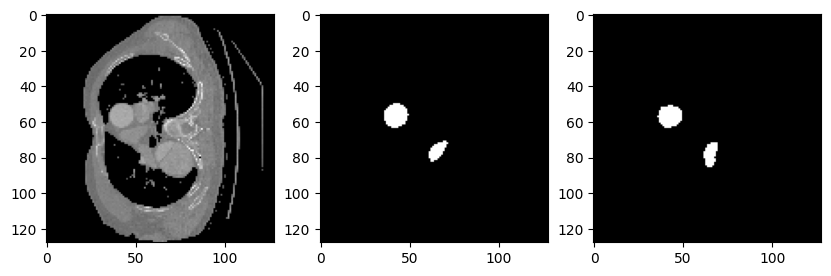

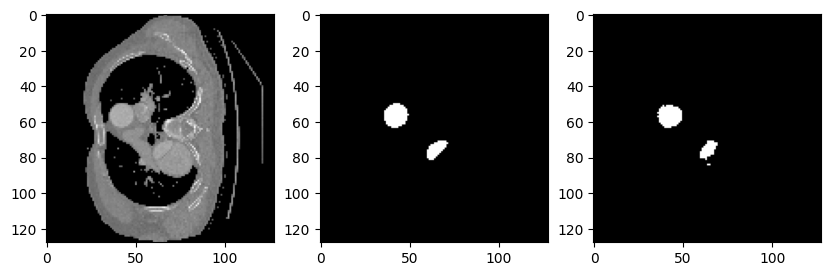

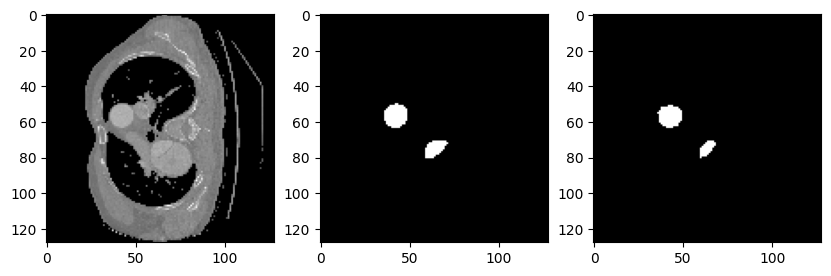

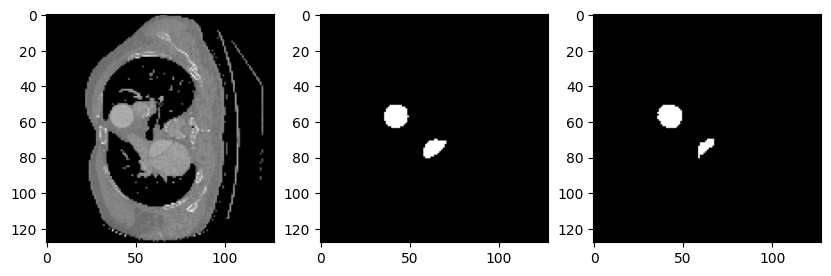

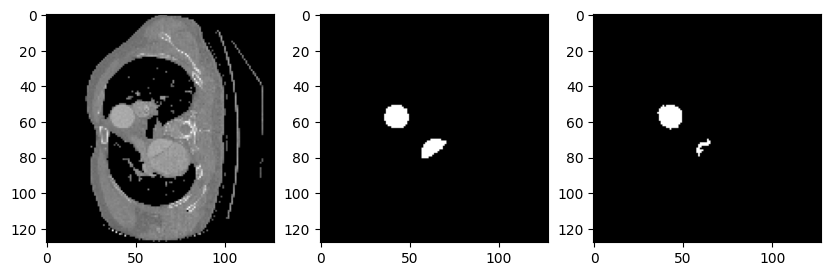

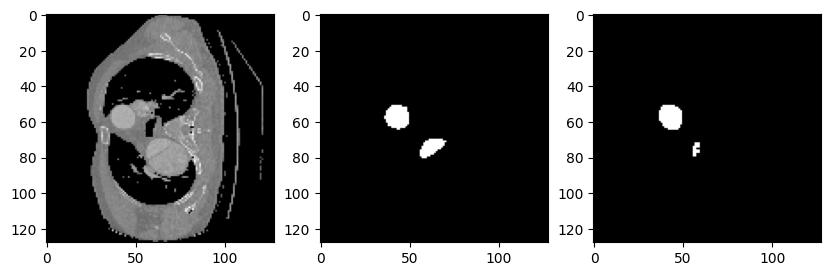

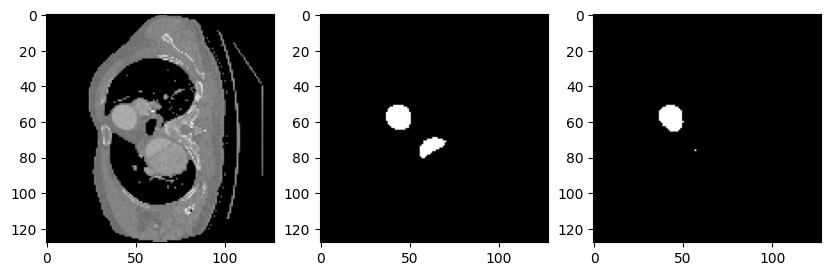

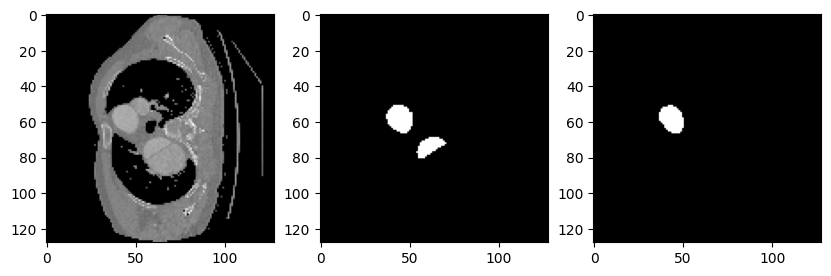

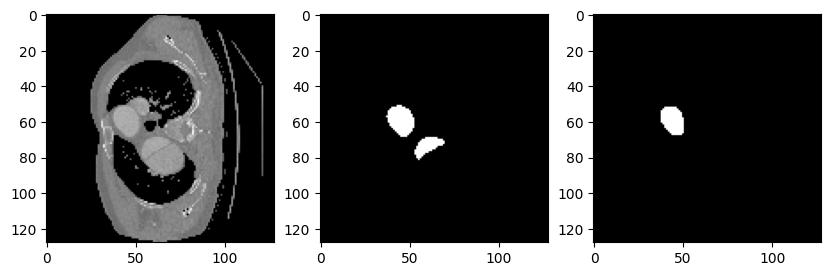

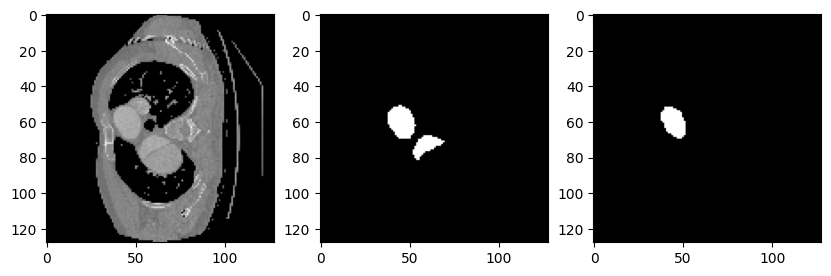

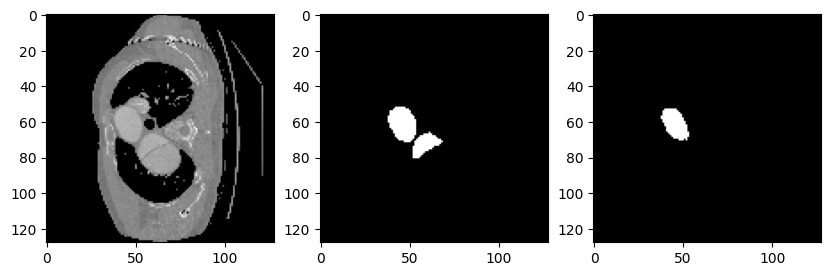

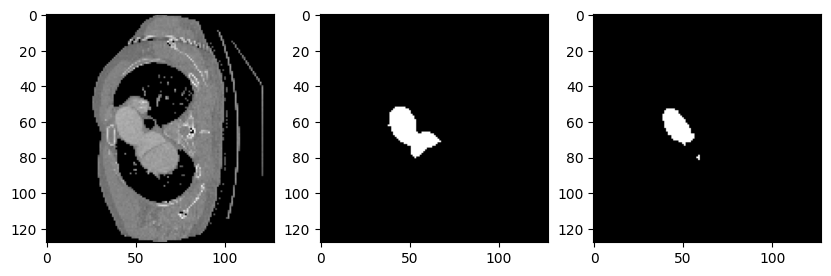

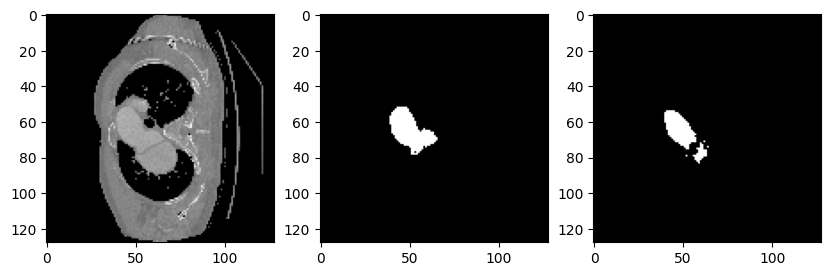

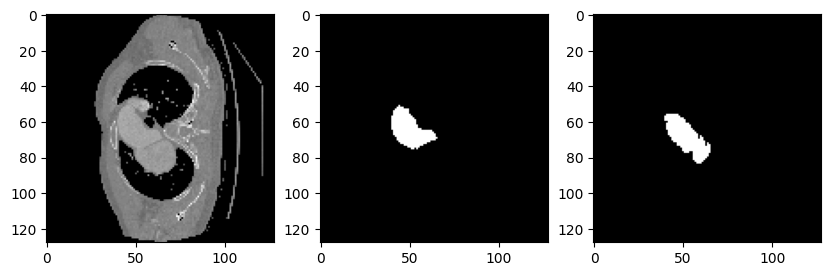

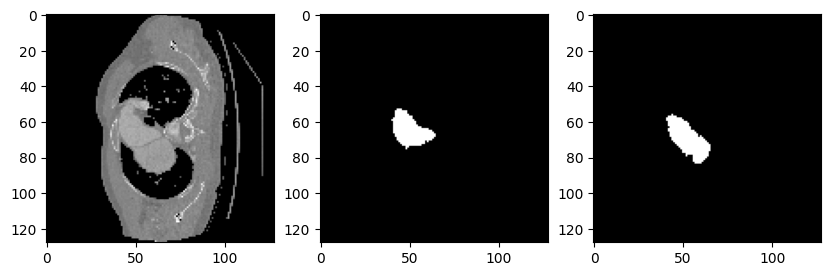

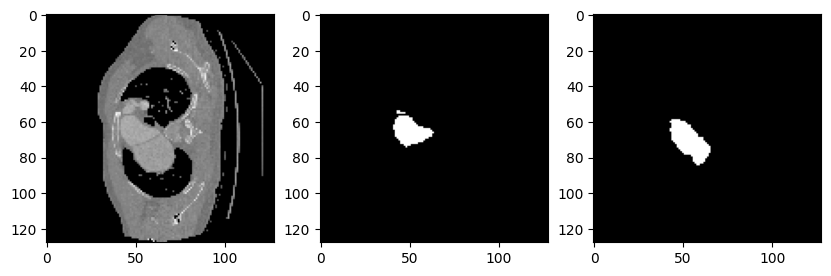

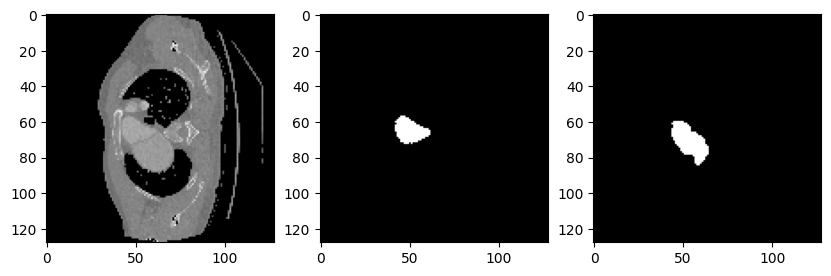

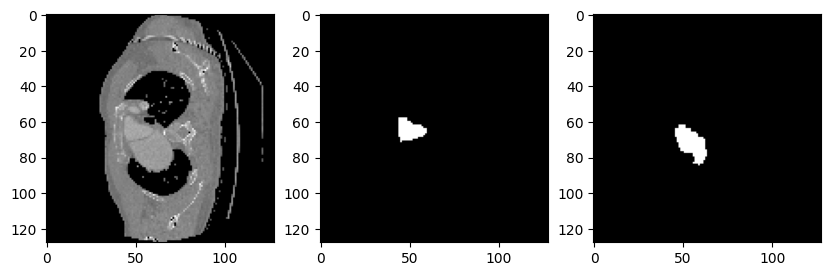

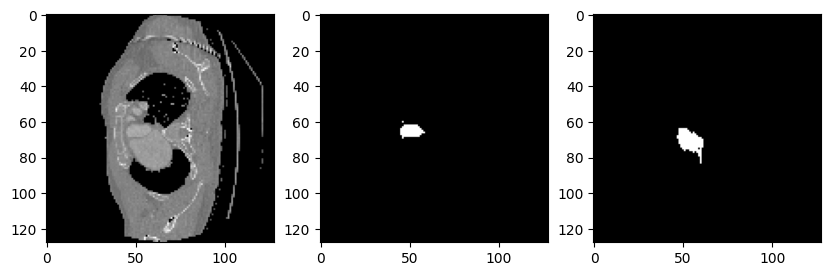

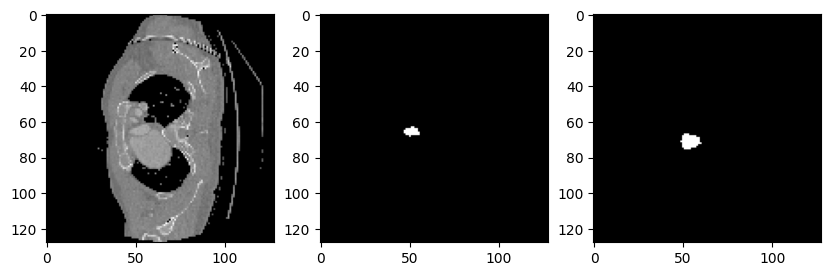

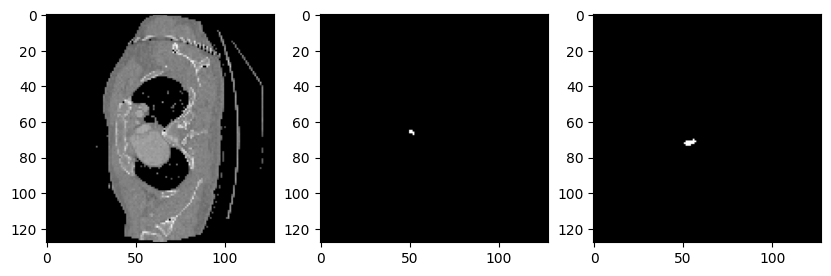

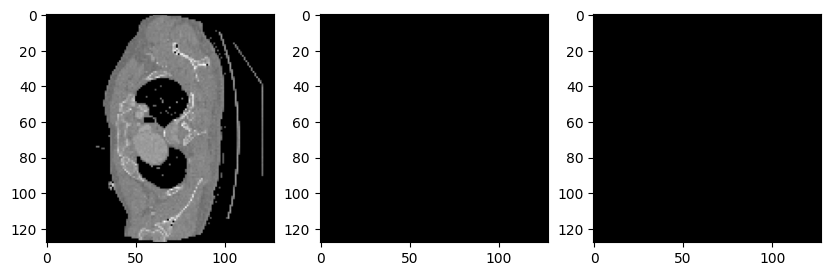

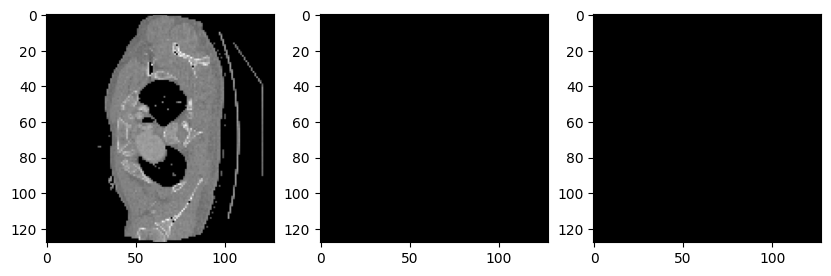

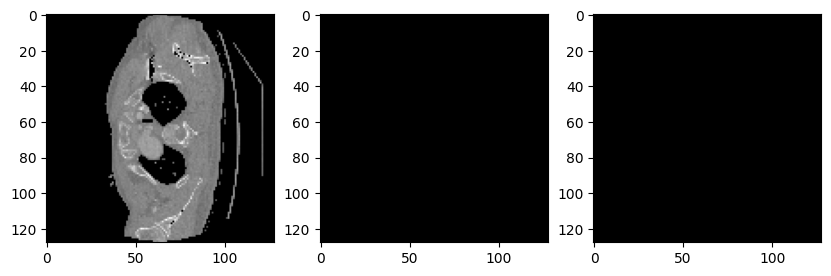

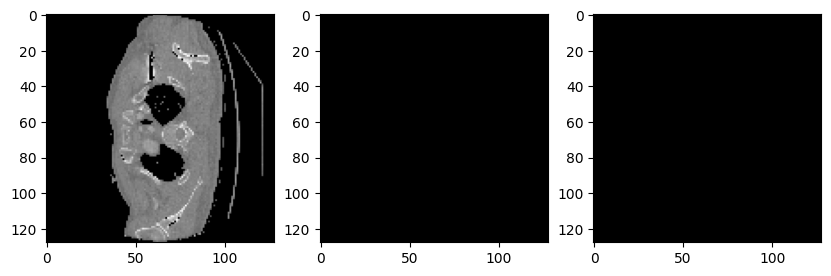

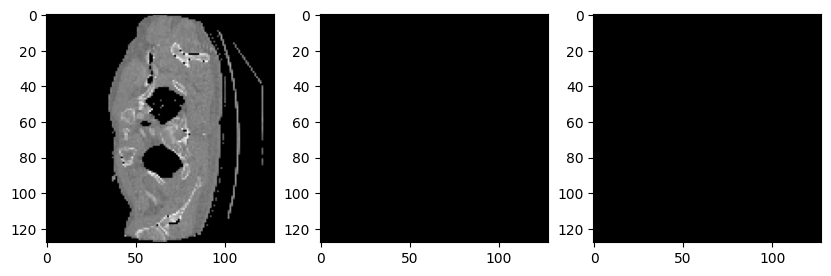

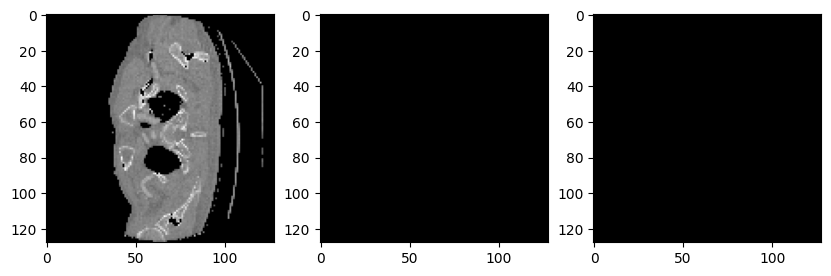

In [29]:
pat_ind = 3
slice_num = image_batch["label"].shape[-1]

for i in list(range(slice_num))[::2]:
    fig, ax = plt.subplots(1, 3, figsize=(10, 30))
    im = image_batch["image"][pat_ind, 0, ..., i].cpu().numpy().copy()
    lab = image_batch["label"][pat_ind, 0, ..., i].cpu().numpy().copy()
    pred = val_outputs[pat_ind][0, ..., i].cpu().numpy().copy()

    ax[0].imshow(im, cmap="gray")
    ax[1].imshow(lab, cmap="gray")
    ax[2].imshow(pred, cmap="gray")
    plt.show()